# ガウス過程 (Gaussian Process)

In [1]:
# ライブラリのインポート
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

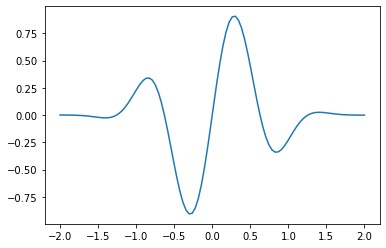

In [2]:
# ターゲット関数
def f(x):
    return np.sin(5 * x) * (1 - np.tanh(x ** 2))

x_grid = np.linspace(-2, 2, 100)
plt.plot(x_grid, f(x_grid))
plt.show()

In [3]:
# x = np.linspace(-2, 2, 8)[:, np.newaxis]
from numpy.random import default_rng
rng = default_rng(seed=0)
x = rng.uniform(low=-2, high=2, size=(10, 1))
x_grid = np.linspace(-2, 2, 100)

def plot_gpr(kernel, ax, text=''):
    from sklearn.gaussian_process import GaussianProcessRegressor
    gpr = GaussianProcessRegressor(
        kernel=kernel,
    )
    _ = gpr.fit(x, f(x))

    mean, std = gpr.predict(x_grid[:, np.newaxis], return_std=True)
    ax.plot(x_grid, mean, label='GP')
    ax.fill_between(x_grid, (mean + std), (mean - std), alpha=0.3, label=None)

    ax.plot(x_grid, f(x_grid), linestyle='dashed', label='truth')
    ax.scatter(x, f(x), color='black', label='obs.')

    ax.legend(loc='lower left', fontsize='small')
    ax.text(0.01, 0.9, text, transform=ax.transAxes, fontsize='large')

    return gpr

def sample_grp(kernel, ax, text, num_samples=10):
    from sklearn.gaussian_process import GaussianProcessRegressor
    gpr = GaussianProcessRegressor(
        kernel=kernel,
    )

    y = gpr.sample_y(x_grid[:, np.newaxis], num_samples)
    _ = ax.plot(x_grid, y)
    ax.text(0.01, 1.01, text, transform=ax.transAxes, fontsize='large')


## RBF kernel
$$
k(x_i, x_j) = \exp \left( -\frac{||x_i - x_j||^2}{2l^2} \right)
$$
length scale($l$)がハイパーパラメータ。


### 事前分布からのサンプリング

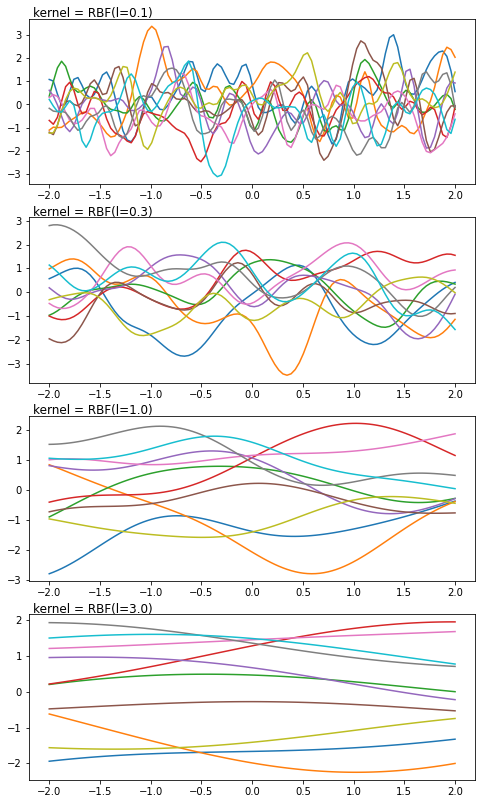

In [4]:
from sklearn.gaussian_process.kernels import RBF

fig = plt.figure(figsize=(8, 14))
for i, l in enumerate([0.1, 0.3, 1., 3.]):
    ax = fig.add_subplot(4, 1, 1 + i)
    sample_grp(
        kernel=RBF(l, length_scale_bounds='fixed'),
        ax=ax,
        text=f'kernel = RBF(l={l:1.1f})',
        num_samples=10
    )


### データ点へのフィット

#### kernelの大きさを定数倍させたときの変化

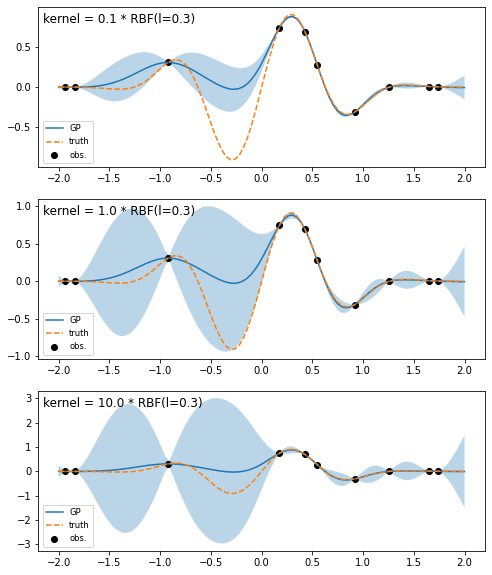

In [5]:
from sklearn.gaussian_process.kernels import ConstantKernel
from sklearn.gaussian_process.kernels import RBF

fig = plt.figure(figsize=(8, 10))
for i, k in enumerate([0.1, 1., 10.]):
    ax = fig.add_subplot(3, 1, 1 + i)
    plot_gpr(
        kernel=ConstantKernel(k, constant_value_bounds='fixed') * RBF(0.3, length_scale_bounds='fixed'),
        ax=ax,
        text=f'kernel = {k:1.1f} * RBF(l=0.3)'
    )

#### length scale(l)を変えたときの変化

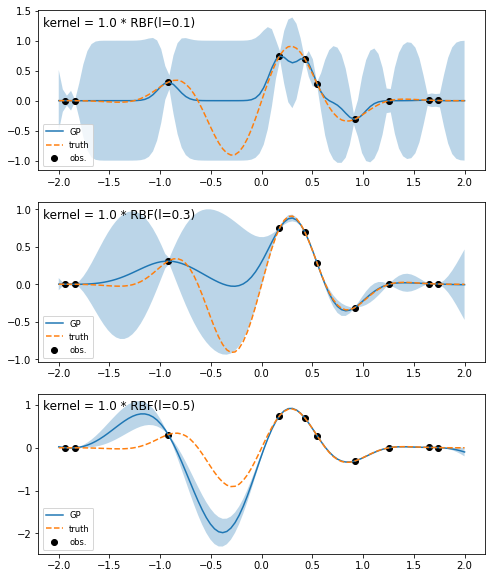

In [6]:
fig = plt.figure(figsize=(8, 10))
for i, l in enumerate([0.1, 0.3, 0.5]):
    ax = fig.add_subplot(3, 1, 1 + i)
    plot_gpr(
        kernel=ConstantKernel(1.0, constant_value_bounds='fixed') * RBF(l, length_scale_bounds='fixed'),
        ax=ax,
        text=f'kernel = 1.0 * RBF(l={l:1.1f})'
    )

## Matern kernel
$$
k(x_i, x_j) = \frac{1}{\Gamma(\nu)2^{\nu-1}}\left( \frac{\sqrt{2\nu}}{l}||x_i - x_j||^2 \right)^{\nu} K_{\nu}\left( \frac{\sqrt{2\nu}}{l}||x_i - x_j||^2 \right)
$$

length scale ($l$)とnu ($\nu$)の2つのハイパーパラメータを持ちます。$\nu$が大きいほどなめらかな分布となります。

Matern kernelは$\nu$が特定の値の時、よく知られた他のkernelと同じ形になります。
$\nu\rightarrow\infty$ の時、Matern kernelはRBF kernelになります。
$\nu = 1/2$ の時、Matern kernelは指数カーネル($k(x_i, x_j) = \exp \left( -\frac{||x_i - x_j||^2}{l}\right)$)になります。


### 事前分布からのサンプリング

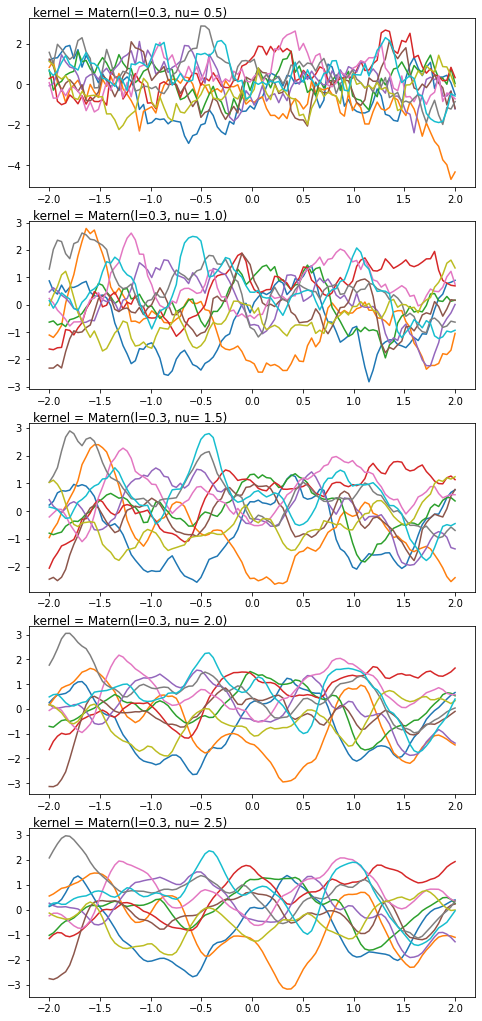

In [7]:
from sklearn.gaussian_process.kernels import Matern

fig = plt.figure(figsize=(8, 18))
for i, nu in enumerate([0.5, 1.0, 1.5, 2.0, 2.5]):
    ax = fig.add_subplot(5, 1, 1 + i)
    sample_grp(
        kernel=Matern(0.3, length_scale_bounds='fixed', nu=nu),
        ax=ax,
        text=f'kernel = Matern(l=0.3, nu={nu: 1.1f})',
        num_samples=10
    )


### データ点へのフィット

#### nu($\nu$)を変化させたときの変化

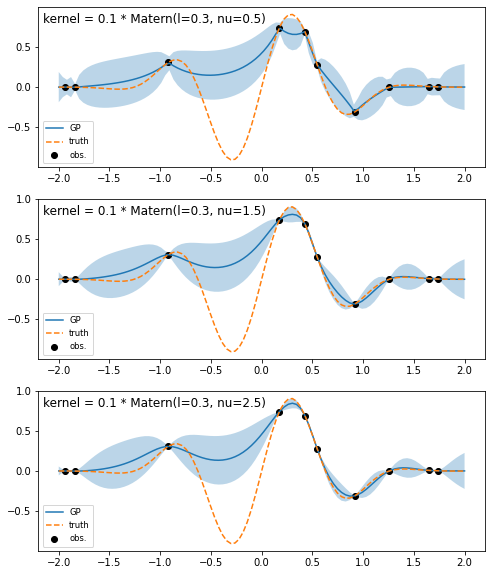

In [8]:
fig = plt.figure(figsize=(8, 10))
for i, nu in enumerate([0.5, 1.5, 2.5]):
    ax = fig.add_subplot(3, 1, 1 + i)
    plot_gpr(
        kernel=ConstantKernel(0.1, constant_value_bounds='fixed') * Matern(0.3, length_scale_bounds='fixed', nu=nu),
        ax=ax,
        text=f'kernel = 0.1 * Matern(l=0.3, nu={nu:1.1f})'
    )

sklearnでは、Kernelのハイパーパラメータをtuningしてくれる機能があります。
Kernelの引数として`constant_value_bounds='fixed'`のようにfixedを指定せず、取り得る値の範囲を指定させると、fitの際にハイパーパラメータチューニングが行われます。

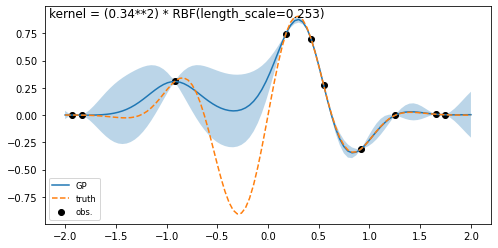

In [9]:
fig, ax = plt.subplots(figsize=(8, 4))
gpr = plot_gpr(
    kernel=ConstantKernel(0.1, constant_value_bounds=(1e-2, 1+2)) * RBF(0.3, length_scale_bounds=(1e-3, 1+2)),
    ax=ax,
)
params = gpr.kernel_.get_params()
_ = ax.text(0.01, 0.95, f'kernel = ({params["k1"]}) * {params["k2"]}', transform=ax.transAxes, fontsize='large')

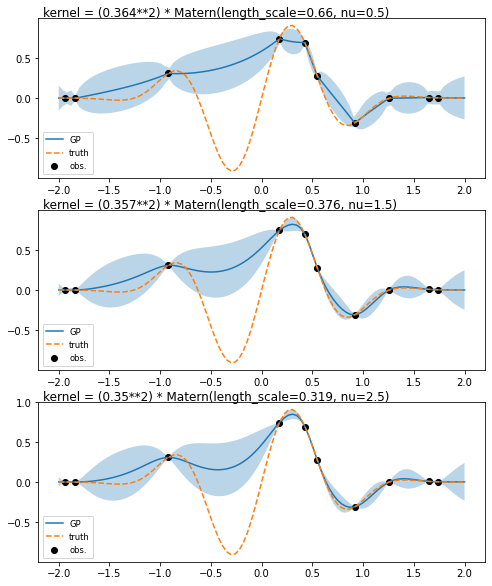

In [10]:
fig = plt.figure(figsize=(8, 10))
for i, nu in enumerate([0.5, 1.5, 2.5]):
    ax = fig.add_subplot(3, 1, 1 + i)
    gpr = plot_gpr(
        kernel=ConstantKernel(0.1, constant_value_bounds=(1e-2, 1+2)) * Matern(0.3, length_scale_bounds=(1e-3, 1+2), nu=nu),
        ax=ax,
    )
    params = gpr.kernel_.get_params()
    ax.text(0.01, 1.01, f'kernel = ({params["k1"]}) * {params["k2"]}', transform=ax.transAxes, fontsize='large')